# Summarization using Attention Layer, stacked LSTMs 
## Seq2seq Encoding Decoding

In [ ]:
#ROUGE (Recall-Oriented Understudy for Gisting Evaluation), 
#metrics and a software package used for evaluating automatic summarization

!pip install rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Attention Layer

Keras doesn't support attention layer officially. We have opted for a third-party implementation of attention layer

In [ ]:
from attention import AttentionLayer

In [ ]:
!pip install keras-preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Sorting out Libraries

In [ ]:
from tensorflow import keras
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
from keras import backend as K
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/Reviews.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content')

# Reading the dataset

## Amazon Fine Food Reviews

In [ ]:
#importing dataset
data = pd.read_csv('Reviews.csv', on_bad_lines='skip')
data = data.loc[:, ['Text', 'Summary']]
data.drop_duplicates('Text', inplace = True)     # drop duplicate reviews
data.dropna(axis = 0, inplace = True)            # drop rows that have NA

In [ ]:
data.head(1)

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food


In [ ]:
len(data)

393576

### Alter the size of the dataset

In [ ]:
data = data.head(50000) 

In [ ]:
len(data)

50000

# Preprocessing the data
## Following preprocessing tasks are performed on data:

Converting to lowercase

Removing HTML tags

Contraction mapping

Removing (‘s)

Removing text inside parenthesis ( )

Removing punctuations and special characters

Removing stopwords

Removing short words


In [ ]:
 #Contraction mapping
#below is the dictionary we'll use to expand the contractions

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
# We'll use NLTK to get the stop words

import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = data.rename(columns={'article': 'Text', 'highlights': 'Summary'})

In [ ]:
cleaned_text = []
cleaned_summary = []

In [ ]:
## cleaning the non summarised data
def text_cleaner(text):
    
    # Converting to lowercase
    cleaned = text.lower()

    # Removing HTML tags
    cleaned = BeautifulSoup(cleaned, "lxml").text

    # Removing (‘s), punctuations, text inside parenthesis ( ), and special characters
    cleaned = re.sub(r"\([^)]*\)", "", cleaned)
    cleaned = re.sub('"', '', cleaned)
    cleaned = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in cleaned.split(" ")])    
    cleaned = re.sub(r"'s\b","",cleaned)
    cleaned = re.sub("[^a-zA-Z]", " ", cleaned) 
       
    tokens = [w for w in cleaned.split() if w not in stop_words]
       
    long_words = []
    for i in tokens:
        if len(i) >= 3:
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_text = [text_cleaner(text) for text in data['Text']]

In [ ]:
## cleaning the summary data
def summary_cleaner(text):
    
    cleaned = re.sub('"', '', text)
    cleaned = " ".join([contraction_mapping[t] if t in contraction_mapping else t for t in cleaned.split(" ")])
    cleaned = re.sub(r"'s\b", "", cleaned)
    cleaned = re.sub("[^a-zA-Z]", " ", cleaned)
    cleaned = cleaned.lower()

    tokens = cleaned.split()
    cleaned = ""
    for i in tokens:
        if len(i) > 1: 
            cleaned = cleaned + i + " "
    return cleaned

cleaned_summary = [summary_cleaner(text) for text in data['Summary']]

In [ ]:
## binding the new data to the dataframe
data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace = True)    # replace empty strings with NA
data.dropna(axis = 0, inplace = True)                          # remove rows that are NA 
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: 'startsum ' + x + ' endsum') #adding start and end tokens for each summary 
data.reset_index(drop = True, inplace = True)

In [ ]:
data.head(1)

,Text,Summary,cleaned_text,cleaned_summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,startsum good quality dog food endsum


In [ ]:
# checking out the cleaned versions
for i in range(5):
    print('Review:', data['cleaned_text'][i])
    print('Summary:', data['cleaned_summary'][i])
    print('\n')

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: startsum good quality dog food  endsum


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: startsum not as advertised  endsum


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: startsum delight says it all  endsum


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: startsum cough medicine  endsum


Review: great taffy great price wide assortment yummy taffy delivery quick 

# Let's understand the distribution of sequences

In [ ]:
length_of_texts = []
length_of_summaries = []

for i in range(len(data.index)):
    length_of_texts.append(len(data.at[i, 'cleaned_text'].split()))
    length_of_summaries.append(len(data.at[i, 'cleaned_summary'].split()))

lengths_df = pd.DataFrame({'text': length_of_texts, 
                            'summary': length_of_summaries})

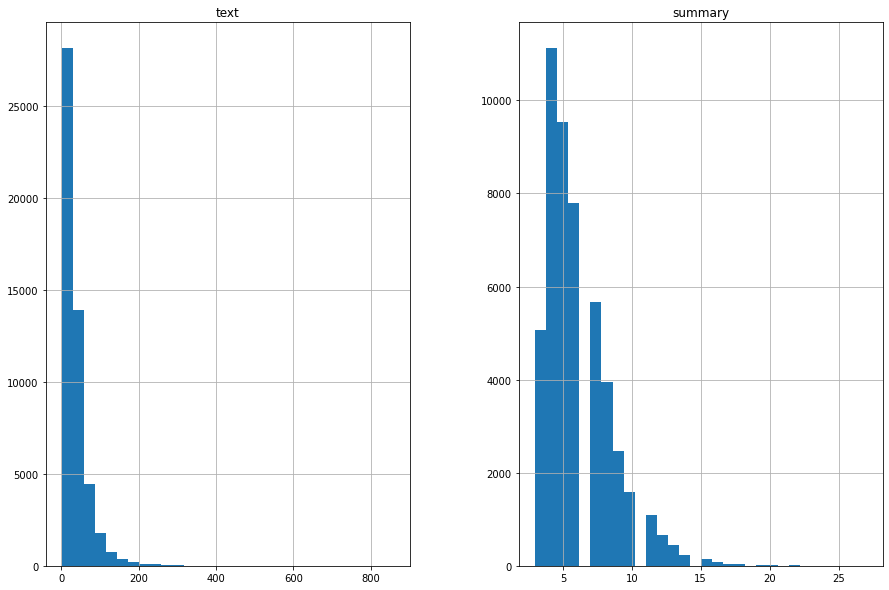

In [ ]:
lengths_df.hist(bins = 30, figsize=(15,10))
plt.show()


### we can fix the maximum text length to 80 as since 91% of sequence are below this length





In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9162947098737015


we can fix the maximum summary length to 10 as since 94% of sequence are below this length


In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9440963951882468


In [ ]:
# Data Transformation
max_len_text = 80
max_len_summary = 10
min_text_word_occurence = 4 #in text any word occuring below this becomes rare
min_summary_word_occurence = 3 #in summary any word occuring below this becomes rare

train_x, train_y = data['cleaned_text'], data['cleaned_summary']

# Tekenizing the Text and Summary

In [ ]:
## Text Tokenizer
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(train_x)

## Rare word coverage in text

In [ ]:
### removing the rare words
## rare words occur less frequently throughout the entire data.
word_freq = text_tokenizer.word_counts.values()
text_voc_size = len(text_tokenizer.word_counts)  
rare_text_voc_size = sum([1 for i in word_freq if i < min_text_word_occurence])  
remaining_coverage = int(1000*sum([i for i in word_freq if i >= min_text_word_occurence])/sum([i for i in word_freq]))/10  
top_n_words_text = text_voc_size - rare_text_voc_size

text_tokenizer = Tokenizer(top_n_words_text)
text_tokenizer.fit_on_texts(train_x)

### convert text sequences into integer sequences
train_x = text_tokenizer.texts_to_sequences(train_x)


### padding up to the maximum length
train_x = pad_sequences(train_x, maxlen = max_len_text, padding = 'post')


text_voc_size = len(text_tokenizer.word_index) + 1 

## Rare word coverage in summary

In [ ]:
## Summary Tokenizer
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(train_y)

## removing the rare words
word_freq = summary_tokenizer.word_counts.values()
summary_voc_size = len(summary_tokenizer.word_counts)   
rare_summary_voc_size = sum([1 for i in word_freq if i < min_summary_word_occurence])  
remaining_coverage = int(1000*sum([i for i in word_freq if i >= min_summary_word_occurence])/sum([i for i in word_freq]))/10  
top_n_words_summary = summary_voc_size - rare_summary_voc_size

summary_tokenizer = Tokenizer(top_n_words_summary)
summary_tokenizer.fit_on_texts(train_y)

### convert text sequences into integer sequences
train_y = summary_tokenizer.texts_to_sequences(train_y)


### padding up to the maximum length
train_y = pad_sequences(train_y, maxlen = max_len_summary, padding = 'post')


summary_voc_size = len(summary_tokenizer.word_index) + 1

In [ ]:
## Deleting summaries that only have 'startsum' and 'endsum'
startsum, endsum = summary_tokenizer.word_index['startsum'], summary_tokenizer.word_index['endsum']
i = [i for i, v in enumerate(train_y) if v[0] == startsum and v[1] == endsum]

train_x, train_y = np.delete(train_x, i, axis = 0), np.delete(train_y, i, axis = 0)


# Model Building (training of weights)

### Below we are stacking multiple(3) LSTMs on top of each other.



In [64]:

K.clear_session()
embedding_dim = 500
latent_dim = 500

## Encoder 
encoder_inputs = layers.Input(shape = (max_len_text, )) 
encoder_emb = layers.Embedding(text_voc_size, embedding_dim, trainable = True)(encoder_inputs) 

## LSTM 1 
encoder_lstm1 = layers.LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb) 

## LSTM 2 
encoder_lstm2 = layers.LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

## LSTM 3 
encoder_lstm3 = layers.LSTM(latent_dim, return_sequences = True, return_state = True) 
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

## LSTM 4 
encoder_lstm4 = layers.LSTM(latent_dim, return_state = True, return_sequences = True) 
encoder_outputs, state_h, state_c = encoder_lstm4(encoder_output3) 

## Set up the decoder. 
decoder_inputs = layers.Input(shape = (None, )) 
decoder_emb_layer = layers.Embedding(summary_voc_size, embedding_dim, trainable = True) 
dec_emb = decoder_emb_layer(decoder_inputs) 

## LSTM using encoder_states as initial state
decoder_lstm = layers.LSTM(latent_dim, return_sequences = True, return_state = True) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) 

## Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])    
# based on the encoder and decoder outputs, determine which nodes are more important

## Concat attention output and decoder LSTM output 
decoder_concat_input = layers.Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

## Dense layer
decoder_dense = layers.TimeDistributed(layers.Dense(summary_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

## Define the model
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      20086500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

#### Sparse categorical cross-entropy as the loss function converts integer sequence to One Hot Vector with ease and alleviates memory issues

In [ ]:
model.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

#### using early stop to stop the training once the validation loss increases

In [ ]:
#Here we have used patience 1 which means how long(epochs) to wait after increase in validation loss
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min', 
                            verbose = 1,
                            patience = 1)

## Training model on 128 batch size and validate it on a holdout set, which would be 10% of the dataset

In [ ]:
history = model.fit(
       [train_x, train_y[:, :-1]],
       train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:],
       epochs = 10,
       batch_size = 128,
       validation_split = 0.1,
       callbacks = [early_stop]
)

Epoch 1/10
348/348 [==============================] - 102s 253ms/step - loss: 2.8460 - acc: 0.5924 - val_loss: 2.5467 - val_acc: 0.6234
Epoch 2/10
348/348 [==============================] - 88s 253ms/step - loss: 2.4243 - acc: 0.6242 - val_loss: 2.3598 - val_acc: 0.6400
Epoch 3/10
348/348 [==============================] - 88s 253ms/step - loss: 2.2423 - acc: 0.6393 - val_loss: 2.2842 - val_acc: 0.6472
Epoch 4/10
348/348 [==============================] - 88s 253ms/step - loss: 2.1263 - acc: 0.6487 - val_loss: 2.2520 - val_acc: 0.6482
Epoch 5/10
348/348 [==============================] - 88s 253ms/step - loss: 2.0299 - acc: 0.6566 - val_loss: 2.2145 - val_acc: 0.6527
Epoch 6/10
348/348 [==============================] - 88s 253ms/step - loss: 1.9457 - acc: 0.6639 - val_loss: 2.1946 - val_acc: 0.6539
Epoch 7/10
348/348 [==============================] - 88s 253ms/step - loss: 1.8633 - acc: 0.6720 - val_loss: 2.2045 - val_acc: 0.6535
Epoch 7: early stopping


# The Diagnostic plot






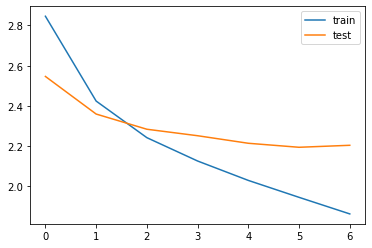

In [ ]:
import matplotlib.pyplot as plt
# Evaluation of plot

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

#### Validation loss increased in the 7th epoch, thus the training stopped. 

In [ ]:
# Building the model to predict the summary


text_index_word = text_tokenizer.index_word
summary_index_word = summary_tokenizer.index_word

text_word_index = text_tokenizer.word_index
summary_word_index = summary_tokenizer.word_index

In [ ]:
# Encoding input sequence to get feature vector


encoder_model = models.Model(
       inputs = encoder_inputs,
       outputs = [encoder_outputs, state_h, state_c]
)

In [ ]:
# Below is Decoder setup


# These are tensors that to hold the states of the previous time step
decoder_state_input_h = layers.Input(shape = (latent_dim, ))
decoder_state_input_c = layers.Input(shape = (latent_dim, ))
decoder_hidden_state_input = layers.Input(shape = (max_len_text, latent_dim))

In [ ]:
# Get the embeddings of decoder sequence


dec_emb2 = decoder_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

In [ ]:
# Finally the Attention Layer


attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = layers.Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])


In [ ]:
# Used the dense softmax layer to generate the probability of every possible summary word


decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [ ]:
# Here is the final decoder model


decoder_model = models.Model(
       [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
       [decoder_outputs2] + [state_h2, state_c2]
)

### Below function is the implementation of the infrence process




In [ ]:
## Actual decoding function
def decode_sequence(input_seq):
       
       
       e_out, e_h, e_c = encoder_model.predict(input_seq)

       
       target_seq = np.zeros((1, 1))

       
       target_seq[0, 0] = summary_word_index['startsum']

       stop_condition = False
       decoded_sentence = ""

       while not stop_condition:
              output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

              
              sampled_token_index = np.argmax(output_tokens[0, -1, :])
              sampled_token = summary_index_word[sampled_token_index]

              if sampled_token != 'endsum':
                     decoded_sentence += sampled_token + " "
              
              
              if sampled_token == 'endsum' or len(decoded_sentence.split()) >= max_len_summary - 1:
                     stop_condition = True
              
              
              target_seq = np.zeros((1, 1))
              target_seq[0, 0] = sampled_token_index

              
              e_h, e_c = h, c
       
       return decoded_sentence

#### Some helper functions to convert integer seq to word seq for both review and summary: 

In [ ]:

def seq2summary(input_seq):
       """
       Function:     To convert a sequence into a summary
       Inputs:       A vector of 10, based on review summaries
       Returns:      A worded summary
       """
       result = ""
       for i in input_seq:
              if i != 0 and i != summary_word_index['startsum'] and i != summary_word_index['endsum']:
                     result += summary_index_word[i] + " "
       return result

In [ ]:
def seq2text(input_seq):
       """
       Function:     To convert a sequence into a text review
       Inputs:       A vector of 100, based on reviews
       Returns:      A worded review
       """
       result = ""
       for i in input_seq:
              if i != 0:
                     result += text_index_word[i] + " "
       return result

---

## Some summaries our model generated

In [ ]:
for i in range(0,10):
    our_summ = decode_sequence(train_x[i].reshape(1, max_len_text))
    print("Review:", seq2text(train_x[i]))
    print("Original summary:", seq2summary(train_y[i]))
    print("Predicted summary:", our_summ)
    print("\n")

1/1 [==============================] - 0s 19ms/step
Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better 
Original summary: good quality dog food 
Predicted summary: great food 


1/1 [==============================] - 0s 19ms/step
Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo 
Original summary: not as advertised 
Predicted summary: not as good as the product 


1/1 [==============================] - 0s 17ms/step
Review: confection around centuries light citrus gelatin nuts case cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lion witch treat selling brother sisters witch 
Original summary: delight says it all 
Predicted summary: great alternative to soda 


1/1 [==============================

In [ ]:
import re
import string
import csv

## Generated the CSV containing 500 original articles, given summaries and model produced summmaries, but it got lost in the midst of session timeouts.

In [ ]:
#Test_data

Test_data = pd.read_csv('Reviews.csv', on_bad_lines='skip')
Test_data = Test_data.loc[:, ['Text', 'Summary']]
Test_data.drop_duplicates('Text', inplace = True)     # drop duplicate reviews
Test_data.dropna(axis = 0, inplace = True) 

In [ ]:
test_data = Test_data.truncate(before = 60000, after = 70000)

In [ ]:
len(test_data)

8288

In [ ]:
test_data.reset_index(inplace = True,drop = True)

In [ ]:
hyps = []
with open('./result_attention.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(500):
        our_summ = decode_sequence(train_x[i].reshape(1, max_len_text))
        #generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.Text[i], test_data.Summary[i], our_summ])

1/1 [==============================] - 0s 20ms/step


# Rouge Score

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.Summary, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.014338888888888892,
  'p': 0.023685714285714282,
  'f': 0.016614979219824806},
 'rouge-2': {'r': 0.001, 'p': 0.002, 'f': 0.0013333333244444445},
 'rouge-l': {'r': 0.014338888888888892,
  'p': 0.023685714285714282,
  'f': 0.016614979219824806}}